<a href="https://colab.research.google.com/github/jfink09/Deep-Learning/blob/main/04_pytorch_video_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 04. PyTorch custom datasets video notebook:

Getting my own data into PyTorch via custom datasets

### 0.0. Importing PyTorch and setting up device agnostic code

In [1]:
import torch
from torch import nn

# Note: PyTorch 1.10.0+ is required for this course
torch.__version__

'1.12.1+cu113'

In [2]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1.0. Get data

The dataset is a subset of the Food101 set.

Food101 starts with 101 classes of food (750 training and 250 testing images).

Our dataset starts with 3 classes and only 10% of the images (~75 training and ~25 testing images).

In [6]:
import requests
import zipfile
from pathlib import Path

# Set up a path to a data folder
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

# If the image folder does not exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory already exists...skipping download.")
else:
  print(f"{image_path} does not exist...creating one")
  image_path.mkdir(parents=True,exist_ok=True)

# Download pizza, steak, and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, and sushi data...")
  f.write(request.content)

# Unzip pizza, steak, and sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists...skipping download.
Unzipping pizza, steak, and sushi data...


### 2.0. Becoming one with the data (data preparation and data exploration)

In [7]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [8]:
# Set up train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 3.1. Visualizing an image

Write code to:

1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Open the image with Python's PIL
5. Show the image and print metadata

data/pizza_steak_sushi/train/steak/735441.jpg
steak
Random image path: data/pizza_steak_sushi/train/steak/735441.jpg
Image class: steak
Image height: 512
Image width: 512


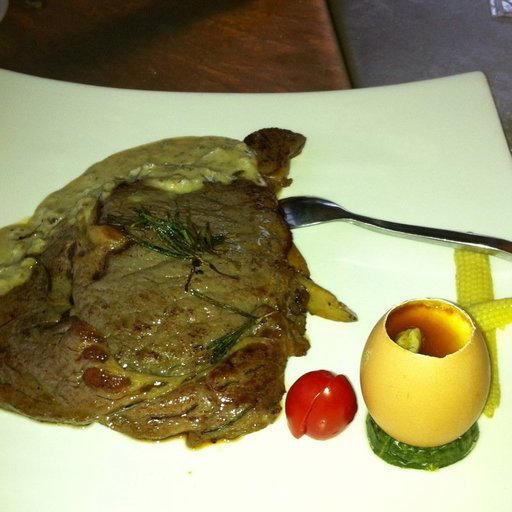

In [13]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

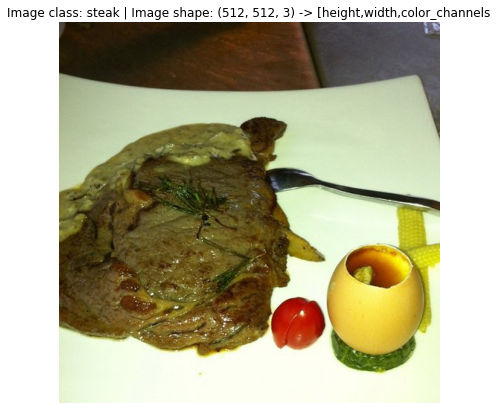

In [14]:
# Visualize with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height,width,color_channels] (HWC)")
plt.axis(False);